## 라이브러리

In [50]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 처리
plt.rc("font", family = "Malgun Gothic")

# 기호 처리
plt.rcParams["axes.unicode_minus"] = False

# 경고 무시 설정
import warnings
warnings.filterwarnings('ignore')

# 시간 확인
from datetime import datetime

# 오버샘플링
from imblearn.over_sampling import SMOTE

# 모델링
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import lightgbm as lgb
import xgboost as xgb

## 다중 CSI 함수

In [4]:
# 다중 CSI 함수
def calculate_csi(y_test, y_pred):
    H11 = H22 = H33 = 0
    F12 = F13 = F21 = F23 = F31 = F32 = 0
    M14 = M24 = M34 = 0
    C44 = F41 = F42 = F43 = 0
    
    y_test = y_test + 1
    y_pred = y_pred + 1
    
    for test, pred in zip(y_test, y_pred) :
        if test == 1 :
            if pred == 1 :
                H11 += 1
            elif pred == 2 :
                F12 += 1
            elif pred == 3 :
                F13 += 1
            else :
                M14 += 1
        elif test == 2 :
            if pred == 1 :
                F21 += 1
            elif pred == 2 :
                H22 += 1
            elif pred == 3 :
                F23 += 1
            else :
                M24 += 1
        elif test == 3 :
            if pred == 1 :
                F31 += 1
            elif pred == 2 :
                F32 += 1
            elif pred == 3 :
                H33 += 1
            else :
                M34 += 1
        else :
            if pred == 1 :
                F41 += 1
            elif pred == 2 :
                F42 += 1
            elif pred == 3 :
                F43 += 1
            else :
                C44 += 1
    
    H = H11 + H22 + H33
    F = F12 + F13 + F21 + F23 + F31 + F32 + F41 + F42 + F43
    M = M14 + M24 + M34
    
    csi = H / (H + F + M)
    
    return csi

## 데이터 불러오기

In [5]:
# 데이터 불러오기
fog_train = pd.read_csv("./data/fog_train.csv") # 3,156,459행
fog_test = pd.read_csv("./data/fog_test.csv") # 262,800행

# 첫 번째 열 삭제
df_train = fog_train.iloc[:, 1:].copy()
df_test = fog_test.copy()

# 컬럼 이름 통일
df_train.columns = [col.split('.')[-1] for col in df_train.columns]
df_test.columns = [col.split('.')[-1] for col in df_test.columns]

In [6]:
# df_train의 vis1 컬럼 삭제
df_train.drop(columns=['vis1'], inplace=True)

In [7]:
# year 컬럼 숫자로 변환
df_train['year'] = df_train['year'].map({'I': 1, 'J': 2, 'K': 3, 'L': 4})
df_test['year'] = df_test['year'].map({'I': 1, 'J': 2, 'K': 3, 'L': 4})

## 데이터 전처리

### 결측치 처리

#### 종속변수 컬럼

In [8]:
# df_train
# class가 -99값을 가지는 결측치 삭제
df_train = df_train[df_train['class'] != -99]

In [9]:
# df_test
# class 모두 NaN값으로 변경
df_test['class'] = np.nan

#### 독립변수 컬럼

In [10]:
# df_train
# 지역별로 구분하기 위한 딕셔너리 생성
df_train_stn = {}

# 종류별로 데이터프레임 분할하여 딕셔너리에 저장
for stn_id in df_train['stn_id'].unique():
    df_train_stn[f'df_train_{stn_id}'] = df_train[df_train['stn_id'] == stn_id].copy()

# 결과 확인 및 데이터프레임 변수에 담기
for name, df in df_train_stn.items():
    locals()[name] = df

# 선형보간법 적용할 컬럼
columns_to_interpolate = ['ws10_deg', 'ws10_ms', 'ta', 're', 'hm', 'sun10', 'ts']

for key, df in df_train_stn.items():
    df.replace(-99.9, np.nan, inplace=True)
    for column in columns_to_interpolate:
        # 선형 보간법을 사용하여 결측치 채우기
        df[column].interpolate(method='linear', inplace=True)
        # 선형 보간 후 남아 있는 결측치를 앞 채우기와 뒤 채우기 사용
        df[column].ffill(inplace=True)
        df[column].bfill(inplace=True)

# 데이터프레임 하나로 합치기
df_train_dfs = []

for key, df in df_train_stn.items():
    df_train_dfs.append(df)
    
combined_df = pd.concat(df_train_dfs, ignore_index=True)

# df_train에 저장
df_train = combined_df.copy()

# 결측치 확인
df_train.isnull().sum()

year        0
month       0
day         0
time        0
minute      0
stn_id      0
ws10_deg    0
ws10_ms     0
ta          0
re          0
hm          0
sun10       0
ts          0
class       0
dtype: int64

In [11]:
# df_test
# 지역별로 구분하기 위한 딕셔너리 생성
df_test_stn = {}

# 종류별로 데이터프레임 분할하여 딕셔너리에 저장
for stn_id in df_test['stn_id'].unique():
    df_test_stn[f'df_test_{stn_id}'] = df_test[df_test['stn_id'] == stn_id].copy()

# 결과 확인 및 데이터프레임 변수에 담기
for name, df in df_test_stn.items():
    locals()[name] = df

# 선형보간법 적용할 컬럼
columns_to_interpolate = ['ws10_deg', 'ws10_ms', 'ta', 'ts', 're', 'hm', 'sun10']

for key, df in df_test_stn.items():
    df.replace(-99.9, np.nan, inplace=True)
    for column in columns_to_interpolate:
        # 선형 보간법을 사용하여 결측치 채우기
        df[column].interpolate(method='linear', inplace=True)
        # 선형 보간 후 남아 있는 결측치를 앞 채우기와 뒤 채우기 사용
        df[column].ffill(inplace=True)
        df[column].bfill(inplace=True)

# 데이터프레임 하나로 합치기
df_test_dfs = []

# 데이터프레임을 하나의 데이터프레임으로 합치기
for key, df in df_test_stn.items():
    df_test_dfs.append(df)
    
combined_df = pd.concat(df_test_dfs, ignore_index=True)

# df_test 저장
df_test = combined_df.copy()

# 결측치 확인
df_test.isnull().sum()

year             0
month            0
day              0
time             0
minute           0
stn_id           0
ws10_deg         0
ws10_ms          0
ta               0
re               0
hm               0
sun10            0
ts               0
class       262800
dtype: int64

### 지점 번호 원핫 인코딩

In [12]:
# 원핫 인코딩
# df_train
df_onehot = df_train.copy()
df_onehot['stn_id'] = df_onehot['stn_id'].str[0]

df_encoded = pd.get_dummies(df_onehot, dtype=int)

# df_test
df_onehot_test = df_test.copy()
df_onehot_test['stn_id'] = df_onehot_test['stn_id'].str[0]

df_encoded_test = pd.get_dummies(df_onehot_test, dtype=int)

### 파생변수 생성

In [13]:
# 파생변수 생성

# 풍향의 사인 및 코사인
df_encoded['ws10_deg_sin'] = np.sin(np.deg2rad(df_encoded['ws10_deg']))
df_encoded['ws10_deg_cos'] = np.cos(np.deg2rad(df_encoded['ws10_deg']))

df_encoded_test['ws10_deg_sin'] = np.sin(np.deg2rad(df_encoded_test['ws10_deg']))
df_encoded_test['ws10_deg_cos'] = np.cos(np.deg2rad(df_encoded_test['ws10_deg']))

# 풍속의 제곱
df_encoded['ws10_ms_sq'] = df_encoded['ws10_ms'] ** 2
df_encoded_test['ws10_ms_sq'] = df_encoded_test['ws10_ms'] ** 2

# 이슬점 온도
df_encoded['dew_point'] = df_encoded['ta'] - (100 - df_encoded['hm']) / 5
df_encoded_test['dew_point'] = df_encoded_test['ta'] - (100 - df_encoded_test['hm']) / 5

# 절대 습도
T = df_encoded['ta']
RH = df_encoded['hm']
df_encoded['abs_hm'] = (6.112 * np.exp((17.67 * T) / (T + 243.5)) * RH * 2.1674) / (273.15 + T)

T = df_encoded_test['ta']
RH = df_encoded_test['hm']
df_encoded_test['abs_hm'] = (6.112 * np.exp((17.67 * T) / (T + 243.5)) * RH * 2.1674) / (273.15 + T)

# 야간 여부
df_encoded['night'] = ((df_encoded['time'] >= 18) | (df_encoded['time'] < 6)).astype(int)
df_encoded_test['night'] = ((df_encoded_test['time'] >= 18) | (df_encoded_test['time'] < 6)).astype(int)

# 계절
def get_season_code(month):
    if 3 <= month <= 5:
        return 1  # 봄
    elif 6 <= month <= 8:
        return 2  # 여름
    elif 9 <= month <= 11:
        return 3  # 가을
    else:
        return 4  # 겨울

df_encoded['season'] = df_encoded['month'].apply(get_season_code)
df_encoded_test['season'] = df_encoded_test['month'].apply(get_season_code)

## 데이터 모델링

RandomForest, XGBoost, LightGBM, AdaBoost

In [ ]:
def train_models(df):
    models = {
        'LightGBM': LGBMClassifier(random_state=2024),
        'XGBoost': XGBClassifier(random_state=2024),
        'RandomForest': RandomForestClassifier(random_state=2024),
        'AdaBoost': AdaBoostClassifier(random_state=2024)
    }

    results = []

    # 독립변수와 종속변수 분리
    X = df.drop('class', axis=1)
    y = df['class'] - 1
    
    # SMOTE 적용
    smote = SMOTE(random_state=2024)
    X_res, y_res = smote.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=2024)
    
    for model_name, model in models.items():
        # 시작 시간
        start_date = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        
        print(f"{model_name}")

        # 모델 훈련
        model.fit(X_train, y_train)

        # 모델 저장
        model_filename = f'{model_name}.pkl'
        joblib.dump(model, model_filename)

        # 예측 수행
        y_pred = model.predict(X_test)

        # 정확도 및 혼동 행렬 계산
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # F1 스코어, 정밀도, 재현율 계산
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        # 다중 CSI 계산
        csi = calculate_csi(y_test, y_pred)

        # AUC 계산
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
            auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
        else:
            auc = np.nan

        # 변수 중요도 추출
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_
        else:
            feature_importances = np.nan

        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importances
        }).sort_values(by='importance', ascending=False)

        # 결과 저장
        results.append({
            'model': model_name,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'csi': csi,
            'auc': auc,
            'confusion_matrix': conf_matrix,
            'feature_importance': feature_importance_df
        })
        
        # 혼동 행렬 히트맵 그리기
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        # 끝 시간
        end_date = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        
        # 실행 시간
        print("실행시간 : ", start_date, " ~ ", end_date)
        
    return results

# 함수 호출
results = train_models(df_encoded)

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
results_df

RandomForest


## 평가지표 계산

LightGBM


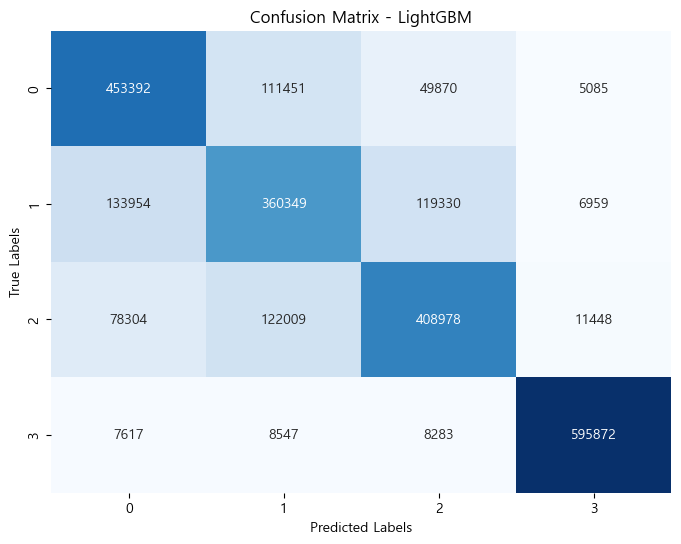

실행시간 :  2024-06-28 07:57:37  ~  2024-06-28 07:59:44
XGBoost


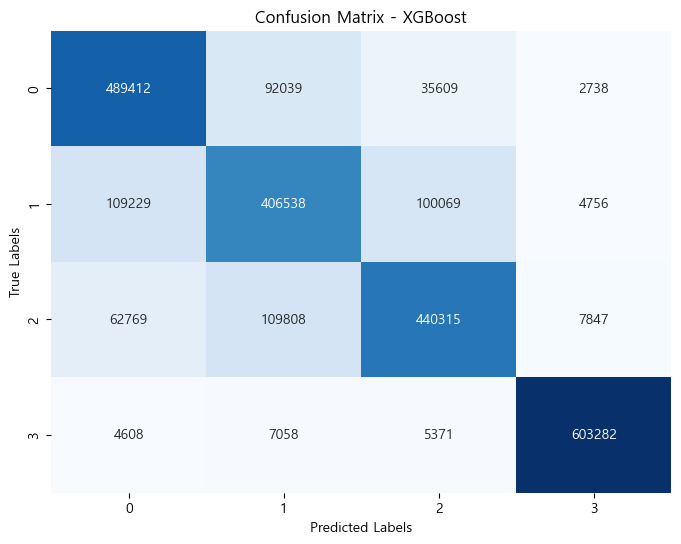

실행시간 :  2024-06-28 07:59:44  ~  2024-06-28 08:00:34
AdaBoost


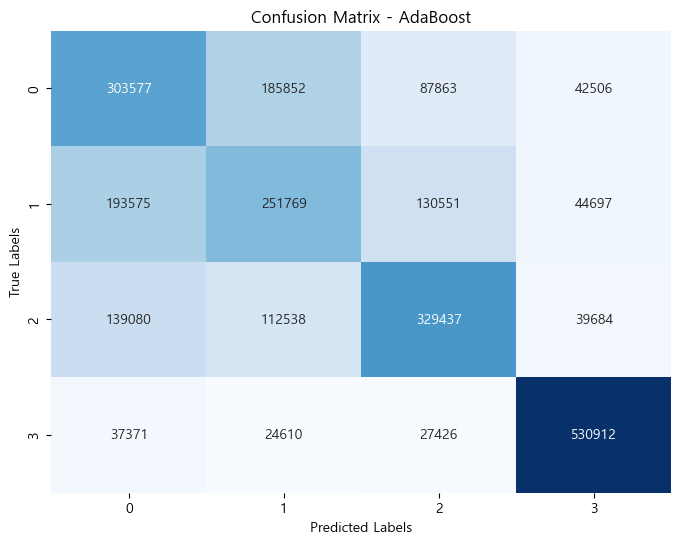

실행시간 :  2024-06-28 08:00:34  ~  2024-06-28 08:06:03
RandomForest


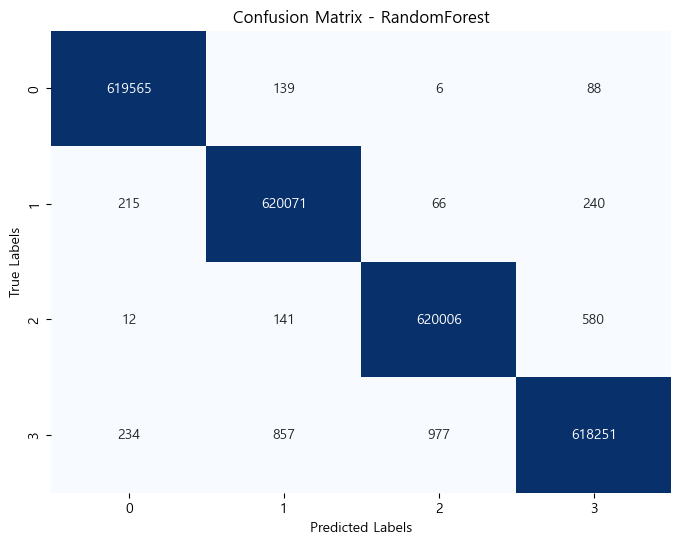

실행시간 :  2024-06-28 08:06:03  ~  2024-06-28 08:32:59


,model,train_accuracy,test_accuracy,f1_score,precision,recall,csi,auc,confusion_matrix,feature_importance
0,LightGBM,0.733364,0.732875,0.732350,0.732764,0.732875,0.648459,0.918170,"[[453392, 111451, 49870, 5085], [133954, 36034...",feature importance 9 hm ...
1,XGBoost,0.782575,0.781619,0.781357,0.781987,0.781619,0.711473,0.941890,"[[489412, 92039, 35609, 2738], [109229, 406538...",feature importance 8 re ...
2,AdaBoost,0.571195,0.570512,0.568084,0.567130,0.570512,0.453610,0.779857,"[[303577, 185852, 87863, 42506], [193575, 2517...",feature importance 8 re ...
3,RandomForest,1.000000,0.998567,0.998567,0.998567,0.998567,0.998092,0.999988,"[[619565, 139, 6, 88], [215, 620071, 66, 240],...",feature importance 9 hm ...


In [15]:
def test_models(df):

    results = []

    # 독립변수와 종속변수 분리
    X = df.drop('class', axis=1)
    y = df['class'] - 1
    
    # SMOTE 적용
    smote = SMOTE(random_state=2024)
    X_res, y_res = smote.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=2024)

    # 모델 파일 경로 설정
    model_paths = {
        'LightGBM': 'LightGBM.pkl',
        'XGBoost': 'XGBoost.pkl',
        'AdaBoost': 'AdaBoost.pkl',
        'RandomForest': 'RandomForest.pkl'
    }


    for model_name, model_path in model_paths.items():
        # 시작 시간
        start_date = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        
        print(f"{model_name}")
        
        with open(model_path, 'rb') as file:
            model = joblib.load(file)
        
        # 예측 수행
        y_pred = model.predict(X_test)

        # 정확도 및 혼동 행렬 계산
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # F1 스코어, 정밀도, 재현율 계산
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')

        # 다중 CSI 계산
        csi = calculate_csi(y_test, y_pred)

        # AUC 계산
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
            auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
        else:
            auc = np.nan

        # 변수 중요도 추출
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_
        else:
            feature_importances = np.nan

        feature_names = X_train.columns
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importances
        }).sort_values(by='importance', ascending=False)

        # 결과 저장
        results.append({
            'model': model_name,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall,
            'csi': csi,
            'auc': auc,
            'confusion_matrix': conf_matrix,
            'feature_importance': feature_importance_df
        })
        
        # 혼동 행렬 히트맵 그리기
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        # 끝 시간
        end_date = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        
        # 실행 시간
        print("실행시간 : ", start_date, " ~ ", end_date)
        
    return results

# 함수 호출
results = test_models(df_encoded)

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
results_df

## 검증 데이터 예측

In [16]:
# 독립변수 추출
X_test = df_encoded_test.drop('class', axis=1)

# 모델 파일 경로 설정
model_paths = {
    'LightGBM': 'LightGBM.pkl',
    'XGBoost': 'XGBoost.pkl',
    'AdaBoost': 'AdaBoost.pkl',
    'RandomForest': 'RandomForest.pkl'
}

# 결과 저장을 위한 함수
def save_predictions(model_name, model, X_test, fog_test):
    # 예측 수행
    y_pred = model.predict(X_test)
    
    # 예측 결과
    pred_data = y_pred + 1

    # fog_test 예측 결과 채우기
    pred_df = fog_test.copy()
    pred_df['fog_test.class'] = pred_data

    # 결과 저장
    pred_df.to_csv(f'fog_test_{model_name}.csv', index=False)

# 각 모델 불러와서 예측 수행 및 저장
for model_name, model_path in model_paths.items():
    with open(model_path, 'rb') as file:
        model = joblib.load(file)
        save_predictions(model_name, model, X_test, fog_test)

## 트리 그리기

XGBoost

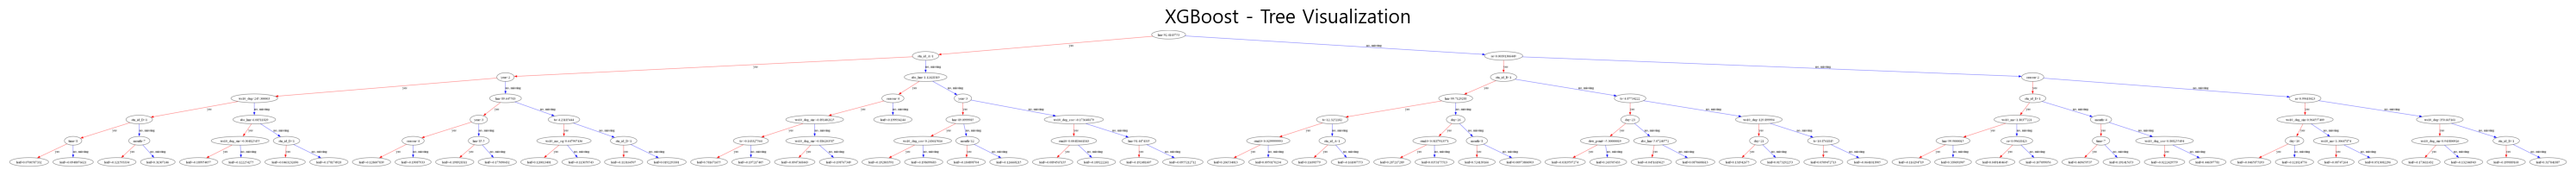

모델 'XGBoost'의 트리 개수: 400
모델 'XGBoost'의 평균 트리의 리프 노드 개수: 61.07


In [62]:
model_paths = {
    'XGBoost': 'XGBoost.pkl'
}

for model_name, model_path in model_paths.items():
    with open(model_path, 'rb') as file:
        model = joblib.load(file)
    plt.figure(figsize=(30, 5))
    xgb.plot_tree(model, ax=plt.gca())
    plt.title(f'{model_name} - Tree Visualization', fontsize=16)
    plt.tight_layout()
    plt.savefig('./savefig/xgboost_tree.png', dpi=300)
    plt.show()
    
    # 트리 개수 얻기
    booster = model.get_booster()
    num_trees = len(booster.get_dump())
    
    # 각 트리의 리프 노드 개수 가져오기
    num_leaves = []
    for tree in booster.get_dump():
        tree_leaves = tree.count('leaf')
        num_leaves.append(tree_leaves)

    # 모델 복잡성 출력
    print(f"모델 '{model_name}'의 트리 개수: {num_trees}")
    print(f"모델 '{model_name}'의 평균 트리의 리프 노드 개수: {sum(num_leaves) / len(num_leaves):.2f}")

## 변수 중요도 시각화

XGBoost

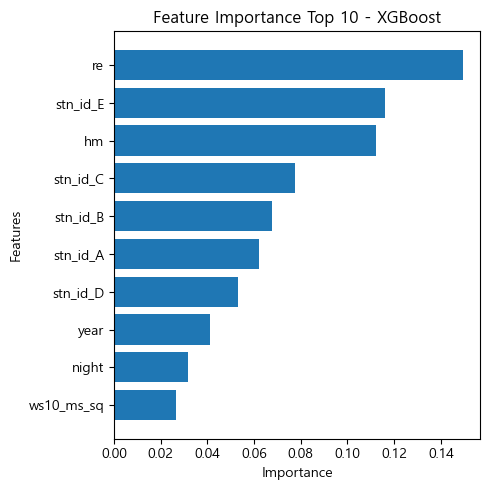

In [82]:
# 변수 중요도 데이터프레임 생성
feature_importance_df = results_df['feature_importance'][1].sort_values(by='importance', ascending=True).tail(10)

# 시각화
plt.figure(figsize=(5, 5))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance Top 10 - XGBoost')
plt.tight_layout()
plt.savefig('./savefig/xgboost_feature_importance.png', dpi=300)